In [1]:
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession

import matplotlib.pyplot as plt
import matplotlib as mpl
import colorcet as cc

In [3]:
# just making jupyter wider
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### Useful Constants, Setup, etc.

In [4]:
# list of US states
state_names = ["Alabama","Alaska","Arizona","Arkansas","California","Colorado","Connecticut","Delaware","Florida","Georgia","Hawaii","Idaho","Illinois",
               "Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland","Massachusetts","Michigan","Minnesota","Mississippi","Missouri","Montana",
               "Nebraska","Nevada","New Hampshire","New Jersey","New Mexico","New York","North Carolina","North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania",
               "Rhode Island","South Carolina","South Dakota","Tennessee","Texas","Utah","Vermont","Virginia","Washington","West Virginia","Wisconsin","Wyoming"]

# function for pulling out states
isState = np.vectorize(lambda x: x in state_names)

# set plotsize and style
plt.rcParams['figure.figsize'] = 16, 5
mpl.style.use('ggplot')

### Load Data

In [5]:
css_confirmed = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
css_confirmed.rename({'Province/State': 'state', 'Country/Region': 'country'}, inplace=True, axis=1)

# most recent day
today = css_confirmed.columns[-1]

In [6]:
css_confirmed[css_confirmed.country == 'US'].sort_values(by=today, ascending=False)

,state,country,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20
99,New York,US,42.1657,-74.9481,0,0,0,0,0,0,...,220,328,421,525,732,967,1706,2495,5365,8310.0
98,Washington,US,47.4009,-121.4905,0,0,0,0,0,0,...,366,442,568,572,643,904,1076,1014,1376,1524.0
100,California,US,36.1162,-119.6816,0,0,0,0,0,0,...,177,221,282,340,426,557,698,751,952,1177.0
107,New Jersey,US,40.2989,-74.5210,0,0,0,0,0,0,...,23,29,29,69,98,178,267,267,742,890.0
110,Illinois,US,40.3495,-88.9861,0,0,0,0,0,0,...,25,32,46,64,93,105,161,162,422,585.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,"Bernalillo, NM",US,35.0178,-106.6291,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
397,"Oakland, MI",US,42.5922,-83.3362,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
398,"Wayne, MI",US,42.2791,-83.3362,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
399,"New Castle, DE",US,39.5393,-75.6674,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN


# Create Useful DataFrames
## Basic Data Aggregation
### Data Aggregated by Country

In [7]:
by_country = css_confirmed[pd.isna(css_confirmed.state)].drop(['state', 'Lat', 'Long'], axis=1)\
                                                        .set_index('country')\
                                                        .sort_values(by=today, ascending=False)

### Data Aggregated by US State

In [8]:
by_state = css_confirmed[isState(css_confirmed.state)].drop(['country', 'Lat', 'Long'], axis=1)\
                                                      .set_index('state')\
                                                      .sort_values(by=today, ascending=False)

## 
### Number of New Confirmed Cases Daily

In [9]:
# create dataframe that tracks new cases on a daily basis
temp = (css_confirmed.values[:, 4:] - np.roll(css_confirmed.values[:, 4:], 1, axis=1))[:, 1:]
new_daily_cases = css_confirmed.drop('1/22/20', axis=1)
new_daily_cases.iloc[:, 4:] = temp
new_daily_cases = new_daily_cases.sort_values(by=today, ascending=False)

### DataFrame for New Cases in US Daily

In [10]:
new_daily_cases_US = new_daily_cases[new_daily_cases.country == 'US'].drop(['country', 'Lat', 'Long'], axis=1)
new_daily_cases_US = new_daily_cases_US[isState(new_daily_cases_US)].groupby('state')\
                                                                    .sum()\
                                                                    .sort_values(by=today, ascending=False)

# Data Visualization
## United States

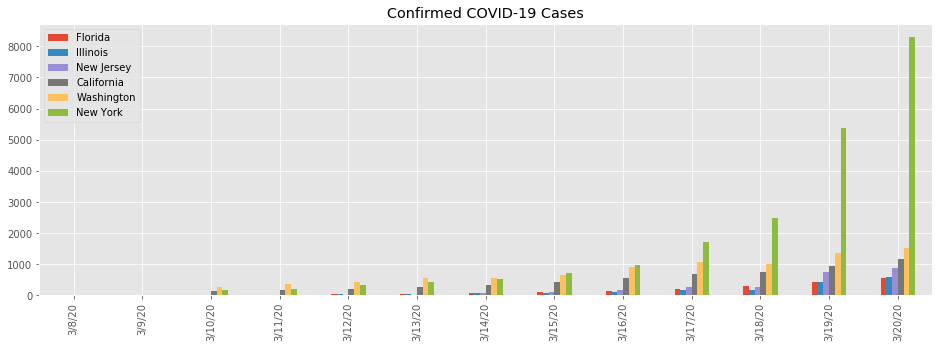

In [11]:
ax = by_state.iloc[:6, 46:][::-1].T.plot(kind='bar')

ax.set_title('Confirmed COVID-19 Cases')
ax.legend(loc='upper left')
plt.show()

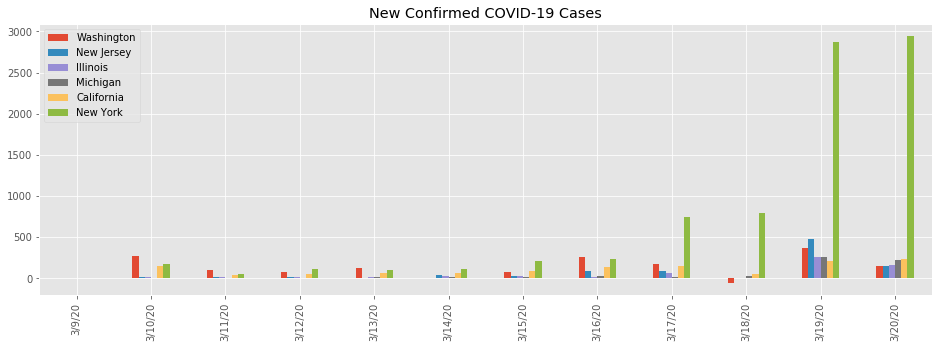

In [12]:
ax = new_daily_cases_US.iloc[:6, 46:][::-1].T.plot(kind='bar')

ax.set_title('New Confirmed COVID-19 Cases')
ax.legend(loc='upper left')

plt.show()

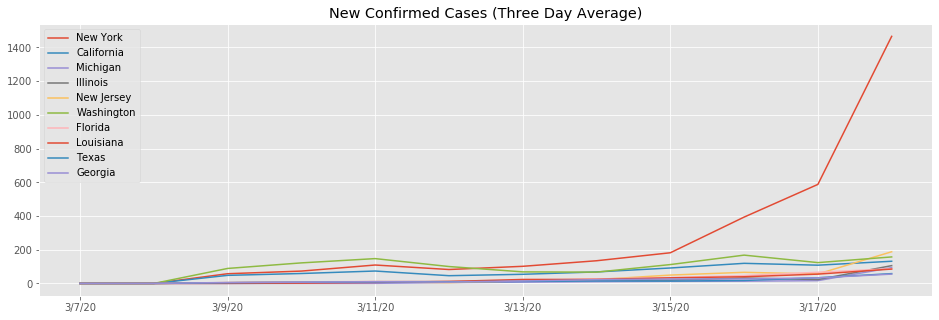

In [13]:
ax = new_daily_cases_US.rolling(3, center=True, axis=1).mean().iloc[:10, 44:].T.plot()

ax.legend(loc='upper left')
ax.set_title('New Confirmed Cases (Three Day Average)')

plt.show()

## Worldwide

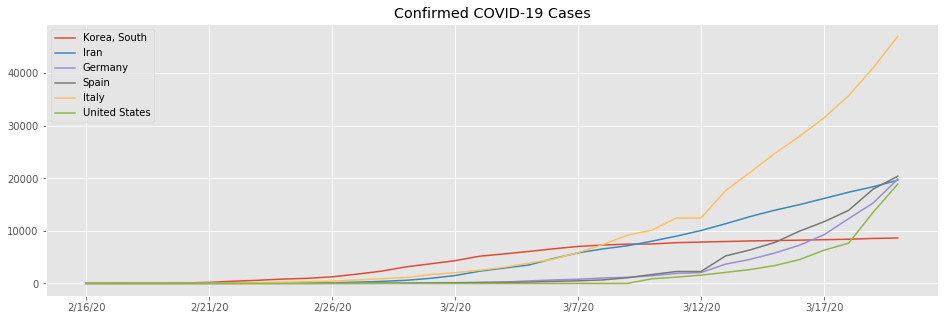

In [14]:
ax = by_country.iloc[:5, 25:][::-1].T.plot()


plt.plot(by_state.sum()[25:], label='United States')

ax.set_title('Confirmed COVID-19 Cases')
ax.legend(loc='upper left')
plt.savefig('covid-by-country.png', dpi=300)
plt.show()

In [15]:
by_country[:30]

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20
country,,,,,,,,,,,,,,,,,,,,,
Italy,0,0,0,0,0,0,0,0,0,2,...,12462,12462,17660,21157,24747,27980,31506,35713,41035,47021.0
Spain,0,0,0,0,0,0,0,0,0,0,...,2277,2277,5232,6391,7798,9942,11748,13910,17963,20410.0
Germany,0,0,0,0,0,1,4,4,4,5,...,1908,2078,3675,4585,5795,7272,9257,12327,15320,19848.0
Iran,0,0,0,0,0,0,0,0,0,0,...,9000,10075,11364,12729,13938,14991,16169,17361,18407,19644.0
"Korea, South",1,1,2,2,3,4,4,4,4,11,...,7755,7869,7979,8086,8162,8236,8320,8413,8565,8652.0
Switzerland,0,0,0,0,0,0,0,0,0,0,...,652,652,1139,1359,2200,2200,2700,3028,4075,5294.0
Austria,0,0,0,0,0,0,0,0,0,0,...,246,302,504,655,860,1018,1332,1646,2013,2388.0
Belgium,0,0,0,0,0,0,0,0,0,0,...,314,314,559,689,886,1058,1243,1486,1795,2257.0
Norway,0,0,0,0,0,0,0,0,0,0,...,598,702,996,1090,1221,1333,1463,1550,1746,1914.0
